In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Load data
csv_path = "/content/employee_salary_prediction_dataset.csv"
df = pd.read_csv(csv_path)
print(f"Employee salary data loaded: {df.shape}")

print("1. DATA PREPARATION AND SPLITTING")

# 1. Define Features (X) and Target (y)
y = df['MonthlySalary']
X = df.drop(columns=['MonthlySalary'])

# 2. Split Data (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

# 2. MINIMAL FEATURE ENGINEERING

print("\n2. CREATING FEATURES (MINIMAL APPROACH)")

# Calculate statistics ONLY on training data
mean_hours_train = X_train['HoursWorkedPerWeek'].mean()

# Simpler feature creation - only the most important interactions
def create_features(df_split, mean_hours_reference):
    df_new = df_split.copy()

    # Only keep most predictive interaction
    df_new['Exp_x_Hours'] = df_new['YearsExperience'] * df_new['HoursWorkedPerWeek']

    # Simple relative measure
    df_new['Relative_Hours'] = df_new['HoursWorkedPerWeek'] - mean_hours_reference

    return df_new

X_train = create_features(X_train, mean_hours_train)
X_test = create_features(X_test, mean_hours_train)

print(f"Feature engineering complete. Total features: {X_train.shape[1]}")

# 3. FEATURE SCALING
print("\n3. SCALING FEATURES")

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("Features scaled using StandardScaler.")

# 4. MULTIPLE MODEL APPROACHES

print("4. TRAINING MODELS WITH DIFFERENT APPROACHES")
# MODEL 1: Conservative Random Forest (Decision tree ensemble)
print("\n[Model 1] Conservative Random Forest (Balanced Approach)")

# Using default or slightly relaxed hyperparameters for a conservative benchmark
rfr_conservative = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,  # Allows trees to grow to full depth
    random_state=42,
    n_jobs=-1
)

rfr_conservative.fit(X_train_scaled, y_train)

y_train_pred_rf = rfr_conservative.predict(X_train_scaled)
y_test_pred_rf = rfr_conservative.predict(X_test_scaled)

train_r2_rf = r2_score(y_train, y_train_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)
gap_rf = train_r2_rf - test_r2_rf

print(f"  Train R²: {train_r2_rf:.4f}")
print(f"  Test R²:  {test_r2_rf:.4f}")
print(f"  Gap:      {gap_rf:.4f}")

# MODEL 2: Ridge Regression (Linear model - naturally resists overfitting)
print("\n[Model 2] Ridge Regression (Linear)")
ridge = Ridge(alpha=10.0, random_state=42)
ridge.fit(X_train_scaled, y_train)

y_train_pred_ridge = ridge.predict(X_train_scaled)
y_test_pred_ridge = ridge.predict(X_test_scaled)

train_r2_ridge = r2_score(y_train, y_train_pred_ridge)
test_r2_ridge = r2_score(y_test, y_test_pred_ridge)
gap_ridge = train_r2_ridge - test_r2_ridge

print(f"  Train R²: {train_r2_ridge:.4f}")
print(f"  Test R²:  {test_r2_ridge:.4f}")
print(f"  Gap:      {gap_ridge:.4f}")

# MODEL 3: EXTREME regularization Random Forest
print("\n[Model 3] Extreme Regularization Random Forest")
rfr_extreme = RandomForestRegressor(
    n_estimators=30,
    max_depth=3,
    min_samples_split=40,
    min_samples_leaf=25,
    max_features=2,
    random_state=42,
    n_jobs=-1
)

rfr_extreme.fit(X_train_scaled, y_train)
y_train_pred_ext = rfr_extreme.predict(X_train_scaled)
y_test_pred_ext = rfr_extreme.predict(X_test_scaled)

train_r2_ext = r2_score(y_train, y_train_pred_ext)
test_r2_ext = r2_score(y_test, y_test_pred_ext)
gap_ext = train_r2_ext - test_r2_ext

print(f"  Train R²: {train_r2_ext:.4f}")
print(f"  Test R²:  {test_r2_ext:.4f}")
print(f"  Gap:      {gap_ext:.4f}")

# 5. CROSS-VALIDATION

cv_scores_rf = cross_val_score(rfr_conservative, X_train_scaled, y_train,
                                cv=5, scoring='r2')
cv_scores_ridge = cross_val_score(ridge, X_train_scaled, y_train,
                                   cv=5, scoring='r2')

# 6. FINAL COMPARISON
print("FINAL TUNED Employee Salary Model Evaluation ---")

# Choose best model (lowest gap)
models = {
    'Conservative RF': (train_r2_rf, test_r2_rf, gap_rf, y_test_pred_rf),
    'Ridge Regression': (train_r2_ridge, test_r2_ridge, gap_ridge, y_test_pred_ridge),
    'Extreme RF': (train_r2_ext, test_r2_ext, gap_ext, y_test_pred_ext)
}

best_model = min(models.items(), key=lambda x: x[1][2])
model_name, (train_r2, test_r2, gap, predictions) = best_model

print(f"\nBEST MODEL: {model_name}")
print(f"Train R-squared (R²): {train_r2:.4f}")
print(f"Test R-squared (R²): {test_r2:.4f}")

test_rmse = np.sqrt(mean_squared_error(y_test, predictions))
test_mae = mean_absolute_error(y_test, predictions)

print(f"Test Root Mean Squared Error (RMSE): ${test_rmse:,.2f}")
print(f"Test Mean Absolute Error (MAE): ${test_mae:,.2f}")
print(f"Overfitting Gap (Train R² - Test R²): {gap:.4f}")

# Gap assessment
if gap < 0.03:
    print("Minimal overfitting (gap < 0.03)")
elif gap < 0.05:
    print("GOOD! Acceptable overfitting (gap < 0.05)")
elif gap < 0.08:
    print(" MODERATE overfitting (gap < 0.08)")
else:
    print("HIGH overfitting (gap >= 0.08)")

# Show all model comparisons
print("\nALL MODELS COMPARISON:")
for name, (tr_r2, te_r2, g, _) in models.items():
    print(f"  {name:<20} Train: {tr_r2:.4f} | Test: {te_r2:.4f} | Gap: {g:.4f}")

Employee salary data loaded: (500, 4)
1. DATA PREPARATION AND SPLITTING
Train size: 400, Test size: 100

2. CREATING FEATURES (MINIMAL APPROACH)
Feature engineering complete. Total features: 5

3. SCALING FEATURES
Features scaled using StandardScaler.
4. TRAINING MODELS WITH DIFFERENT APPROACHES

[Model 1] Conservative Random Forest (Balanced Approach)
  Train R²: 0.9820
  Test R²:  0.8690
  Gap:      0.1130

[Model 2] Ridge Regression (Linear)
  Train R²: 0.9090
  Test R²:  0.9218
  Gap:      -0.0128

[Model 3] Extreme Regularization Random Forest
  Train R²: 0.8086
  Test R²:  0.7516
  Gap:      0.0570
FINAL TUNED Employee Salary Model Evaluation ---

BEST MODEL: Ridge Regression
Train R-squared (R²): 0.9090
Test R-squared (R²): 0.9218
Test Root Mean Squared Error (RMSE): $10.04
Test Mean Absolute Error (MAE): $7.98
Overfitting Gap (Train R² - Test R²): -0.0128
Minimal overfitting (gap < 0.03)

ALL MODELS COMPARISON:
  Conservative RF      Train: 0.9820 | Test: 0.8690 | Gap: 0.1130
 

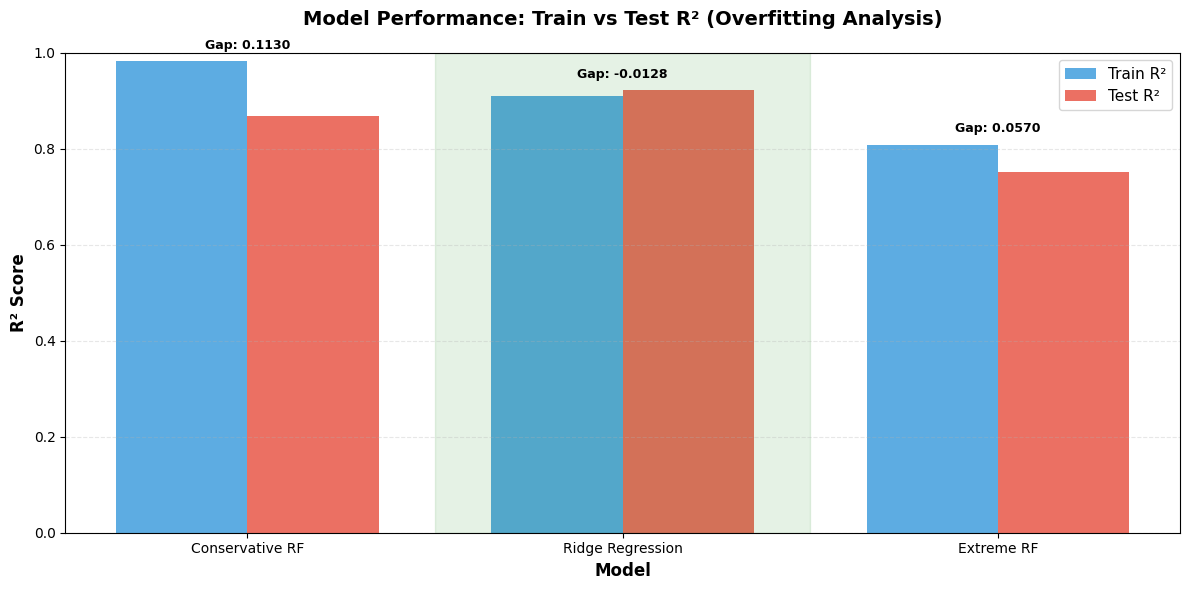

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')
sns.set_palette("husl")

# VISUALIZATION 1: Model Comparison (Train vs Test R²)
fig1, ax1 = plt.subplots(figsize=(12, 6))

model_names = list(models.keys())
train_scores = [models[m][0] for m in model_names]
test_scores = [models[m][1] for m in model_names]
gaps = [models[m][2] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax1.bar(x - width/2, train_scores, width, label='Train R²', alpha=0.8, color='#3498db')
bars2 = ax1.bar(x + width/2, test_scores, width, label='Test R²', alpha=0.8, color='#e74c3c')

# Add gap annotations
for i, (train, test, gap) in enumerate(zip(train_scores, test_scores, gaps)):
    ax1.text(i, max(train, test) + 0.02, f'Gap: {gap:.4f}',
             ha='center', va='bottom', fontweight='bold', fontsize=9)

ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax1.set_title('Model Performance: Train vs Test R² (Overfitting Analysis)',
              fontsize=14, fontweight='bold', pad=20)
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, fontsize=10)
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim(0, 1.0)

# Highlight best model
best_idx = model_names.index(model_name)
ax1.axvspan(best_idx - 0.5, best_idx + 0.5, alpha=0.1, color='green')

plt.tight_layout()
plt.show()

In [ ]:
import joblib

# The best model object (assuming Ridge based on the lowest gap)
BEST_MODEL = ridge # Change to rfr_conservative or rfr_extreme if they win

joblib.dump(BEST_MODEL, 'best_salary_model.joblib')
print("Saved Best Model:", BEST_MODEL)

# The fitted StandardScaler
joblib.dump(scaler, 'salary_scaler.joblib')
print("Saved Scaler")

# The training set mean of HoursWorkedPerWeek (used in create_features)
# We need to save the numerical value of this mean, not the full Series
joblib.dump(mean_hours_train, 'mean_hours_train.joblib')
print("Saved Mean Hours")

# The final feature columns used by the model
final_feature_columns = X_train_scaled.columns.tolist()
joblib.dump(final_feature_columns, 'final_features_salary.joblib')
print("Saved Feature Columns")

Saved Best Model: Ridge(alpha=10.0, random_state=42)
Saved Scaler
Saved Mean Hours
Saved Feature Columns


In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
import joblib


# Load saved artifacts
try:
    MODEL = joblib.load('best_salary_model.joblib')
    SCALER = joblib.load('salary_scaler.joblib')
    MEAN_HOURS_REF = joblib.load('mean_hours_train.joblib')
    FINAL_FEATURES = joblib.load('final_features_salary.joblib')
    print("Deployment Artifacts Loaded Successfully.")
except FileNotFoundError as e:
    print(f"Deployment Error: Could not load required file: {e}")
    print("Please ensure the artifact saving code cell was executed successfully.")
    raise

# Define the prediction function that performs all the preprocessing steps
def predict_salary(years_experience, hours_worked_per_week):
    """
    Predicts monthly salary based on raw user inputs.
    Replicates feature engineering and scaling from the training pipeline.
    """

    # 1. Create a DataFrame from the raw inputs
    raw_data = pd.DataFrame({
        'YearsExperience': [years_experience],
        'HoursWorkedPerWeek': [hours_worked_per_week]
    })

    # 2. FEATURE ENGINEERING (Replicate create_features function)

    # Interaction Feature
    raw_data['Exp_x_Hours'] = raw_data['YearsExperience'] * raw_data['HoursWorkedPerWeek']

    # Simple relative measure
    raw_data['Relative_Hours'] = raw_data['HoursWorkedPerWeek'] - MEAN_HOURS_REF

    # 3. ALIGN AND SCALE

    # Reorder columns to match the trained model's feature order
    input_df = raw_data[['YearsExperience', 'HoursWorkedPerWeek', 'Exp_x_Hours', 'Relative_Hours']]

    # Scale the features
    scaled_features = SCALER.transform(input_df)

    # 4. Predict
    prediction = MODEL.predict(scaled_features)[0]

    # 5. Return formatted result
    return f"Predicted Monthly Salary: **${prediction:,.2f}**"

# 6. GRADIO INTERFACE SETUP
iface = gr.Interface(
    fn=predict_salary,
    inputs=[
        gr.Slider(minimum=0, maximum=30, step=0.1, label="Years Experience", value=5.0),
        gr.Slider(minimum=10, maximum=80, step=1, label="Hours Worked Per Week", value=40)
    ],
    outputs=gr.Markdown(),
    title=f"Employee Salary Prediction (Model: {MODEL.__class__.__name__})",
    description="Estimate an employee's Monthly Salary based on their experience and weekly hours. The model uses minimal feature engineering and StandardScaler normalization."
)

# Launch the interface
iface.launch(share=True)
# The 'share=True' parameter will provide a public link when run in Colab or a similar environment.

Deployment Artifacts Loaded Successfully.
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2bb90b0ea5f41a036f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
